## 공공데이터 API 활용 - 출입국 관광 통계
[출입국 관광 통계 API 문서 링크](https://www.data.go.kr/data/15000297/openapi.do#tab_layer_detail_function)

  ### API 호출 함수

In [56]:
import os
os.chdir(r"C:\Users\lizzy\스파르타_파이썬\웹크롤링")
print(os.getcwd())  # 잘 바뀌었는지 확인

C:\Users\lizzy\스파르타_파이썬\웹크롤링


In [57]:
import requests
import os

def getTourism_stats(yyyymm, nat_cd, ed_cd):
    """
    한국관광공사 API를 통해 월별 관광 통계 데이터 가져오기
    
    Args:
        yyyymm: 년월 (예: '202001')
        nat_cd: 국가코드 (112:중국, 130:일본, 275:미국)
        ed_cd: 'E'(방한외래관광객) 또는 'D'(국민해외관광객)
    
    Returns:
        JSON 형태의 API 응답 데이터
    """
    service_url = 'http://openapi.tour.go.kr/openapi/service/EdrcntTourismStatsService/getEdrcntTourismStatsList'
    service_key = 'sWUTaJy8gAPQz2/8V+B0RaHkFsZ4PJ+wlqn6FT2bFd5VGmdwFJ5DT97wLQJyZ8sWJEz5v5RKeDTvI64Y/PBmmg=='  # 본인의 API 키로 변경하세요
    
    params = {
        'serviceKey': service_key,
        'NAT_CD': nat_cd,
        'ED_CD': ed_cd,
        'YM': yyyymm,
        '_type': 'json',
    }
    
    response = requests.get(service_url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"에러 발생 ({yyyymm}): {response.status_code}")
        return None


  ### API 호출 테스트

In [58]:
# 2020년 1월 중국 관광객 데이터 테스트
test_result = getTourism_stats('202001', '112', 'E')
print(test_result) 

# 결과 확인
try:
    item = test_result['response']['body']['items']['item']
    
    print("=== API 호출 테스트 성공! ===")
    print(f"날짜: {item['ym']}")
    print(f"국가: {item['natKorNm']}")
    print(f"관광객수: {item['num']:,}명")
except :
    print("API 호출 실패 - API 키 및 입력 파라미터를 확인하세요!")

{'response': {'header': {'resultCode': '0000', 'resultMsg': 'OK'}, 'body': {'items': {'item': {'ed': '방한외래관광객', 'edCd': 'E', 'natCd': 112, 'natKorNm': '중  국', 'num': 481681, 'rnum': 1, 'ym': 202001}}, 'numOfRows': 10, 'pageNo': 1, 'totalCount': 1}}}
=== API 호출 테스트 성공! ===
날짜: 202001
국가: 중  국
관광객수: 481,681명


 ### 1) 데이터 수집 및 저장(2020년 1월 ~ 2023년 1월, 3개국)

In [59]:
# 수집 기간 설정
start_ym = 202001  # 2020년 1월
end_ym = 202301    # 2023년 1월

# 수집할 국가 정보 설정
countries = {
    '중국': '112',
    '일본': '130', 
    '미국': '275'
}

# 시작/종료 년월을 년도와 월로 분리
start_year = start_ym // 100
start_month = start_ym % 100
end_year = end_ym // 100
end_month = end_ym % 100

# tourism_data 폴더 생성
os.makedirs('./tourism_data', exist_ok=True)

# 각 국가별로 데이터 수집 및 저장
for country_name, nat_cd in countries.items():
    print(f"\n{'='*50}")
    print(f"{country_name} 데이터 수집 시작...")
    print(f"{'='*50}")
    
    country_data = []  # 해당 국가 데이터만 저장할 리스트
    
    # 시작 년도부터 종료 년도까지 반복
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            yyyymm = f"{year}{month:02d}"
            
            # 시작 년월보다 이전이면 건너뛰기
            if int(yyyymm) < start_ym:
                continue
            
            # 종료 년월보다 이후면 중단
            if int(yyyymm) > end_ym:
                break
            
            # API 호출
            result = getTourism_stats(yyyymm, nat_cd, 'E')
            
            # 데이터 추출 및 저장
            if result:
                try:
                    item = result['response']['body']['items']
                    
                    # 데이터가 있는 경우만 저장
                    if item != "":
                        item = item['item']
                        country_data.append({
                            '날짜': item['ym'],
                            '국가명': item['natKorNm'].replace(' ', ''),  # 공백 제거
                            '관광객수': item['num'],
                        })
                        print(f"{yyyymm}: {item['num']:,}명")
                except:
                    print(f"{yyyymm}: 데이터 없음")
    
    # 해당 국가 데이터를 CSV 파일로 저장
    if country_data:
        file_name = f"{country_name}_{start_ym}_{end_ym}.csv"
        file_path = f'./tourism_data/{file_name}'
        
        # 데이터프레임으로 변환 후 CSV 저장
        df = pd.DataFrame(country_data)
        df.to_csv(file_path, index=False, encoding='utf-8-sig')
        
        print(f"\n{country_name} 저장 완료!")
        print(f"- 파일명: {file_name}")
        print(f"- 데이터 수: {len(country_data)}개")
    else:
        print(f"\n{country_name} 데이터 없음")

print(f"\n{'='*50}")
print(f"전체 수집 및 저장 완료!")
print(f"{'='*50}")


중국 데이터 수집 시작...
202001: 481,681명
202002: 104,086명
202003: 16,595명
202004: 3,935명
202005: 5,124명
202006: 5,051명
202007: 9,738명
202008: 16,275명
202009: 15,307명
202010: 11,477명
202011: 9,174명
202012: 7,987명
202101: 7,346명
202102: 11,982명
202103: 18,980명
202104: 16,830명
202105: 14,221명
202106: 12,942명
202107: 13,469명
202108: 17,103명
202109: 19,144명
202110: 14,035명


ConnectionError: HTTPConnectionPool(host='openapi.tour.go.kr', port=80): Max retries exceeded with url: /openapi/service/EdrcntTourismStatsService/getEdrcntTourismStatsList?serviceKey=sWUTaJy8gAPQz2%2F8V%2BB0RaHkFsZ4PJ%2Bwlqn6FT2bFd5VGmdwFJ5DT97wLQJyZ8sWJEz5v5RKeDTvI64Y%2FPBmmg%3D%3D&NAT_CD=112&ED_CD=E&YM=202111&_type=json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000019AE1BC1F50>: Failed to establish a new connection: [WinError 10014] 호출에 대한 포인터 인수를 사용하려는 동안 시스템에서 잘못된 포인터 주소를 감지했습니다'))

 ### 2) 데이터 통계 및 시각화

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import platform

# OS별 한글 폰트 설정
system = platform.system()

if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif system == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [ ]:
# tourism_data 폴더의 모든 CSV 파일 불러오기
csv_files = glob('./tourism_data/*.csv')

# 모든 데이터를 하나의 데이터프레임으로 합치기
all_dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    all_dfs.append(df)

# 전체 데이터프레임 생성
df_all = pd.concat(all_dfs, ignore_index=True)

# 년도 컬럼 추가
df_all['년도'] = df_all['날짜'].astype(str).str[:4]

print(f"총 데이터 개수: {len(df_all)}개")
print(f"수집 기간: {df_all['날짜'].min()} ~ {df_all['날짜'].max()}")
print(f"국가: {', '.join(df_all['국가명'].unique())}\n")
print("데이터 샘플:")
display(df_all.sample(5))

총 데이터 개수: 111개
수집 기간: 202001 ~ 202301
국가: 미국, 일본, 중국

데이터 샘플:


,날짜,국가명,관광객수,년도
49,202101,일본,1299,2021
97,202112,중국,11691,2021
47,202011,일본,1254,2020
108,202211,중국,24174,2022
24,202201,미국,15570,2022


In [ ]:
# 국가별 통계 요약
print("\n=== 국가별 통계 요약 ===\n")
for country in df_all['국가명'].unique():
    country_df = df_all[df_all['국가명'] == country]
    print(f"📊 {country} ({country_df['날짜'].min()} ~ {country_df['날짜'].max()})")
    print(f"  • 총 관광객 수: {country_df['관광객수'].sum():,}명")
    print(f"  • 월평균: {country_df['관광객수'].mean():,.0f}명")
    print(f"  • 최대: {country_df['관광객수'].max():,}명 ({country_df.loc[country_df['관광객수'].idxmax(), '날짜']})")
    print(f"  • 최소: {country_df['관광객수'].min():,}명 ({country_df.loc[country_df['관광객수'].idxmin(), '날짜']})\n")


=== 국가별 통계 요약 ===

📊 미국 (202001 ~ 202301)
  • 총 관광객 수: 1,017,210명
  • 월평균: 27,492명
  • 최대: 73,560명 (202210)
  • 최소: 6,417명 (202004)

📊 일본 (202001 ~ 202301)
  • 총 관광객 수: 809,774명
  • 월평균: 21,886명
  • 최대: 211,199명 (202002)
  • 최소: 360명 (202004)

📊 중국 (202001 ~ 202301)
  • 총 관광객 수: 1,108,949명
  • 월평균: 29,972명
  • 최대: 481,681명 (202001)
  • 최소: 3,935명 (202004)



C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41968\641887034.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_by_country,


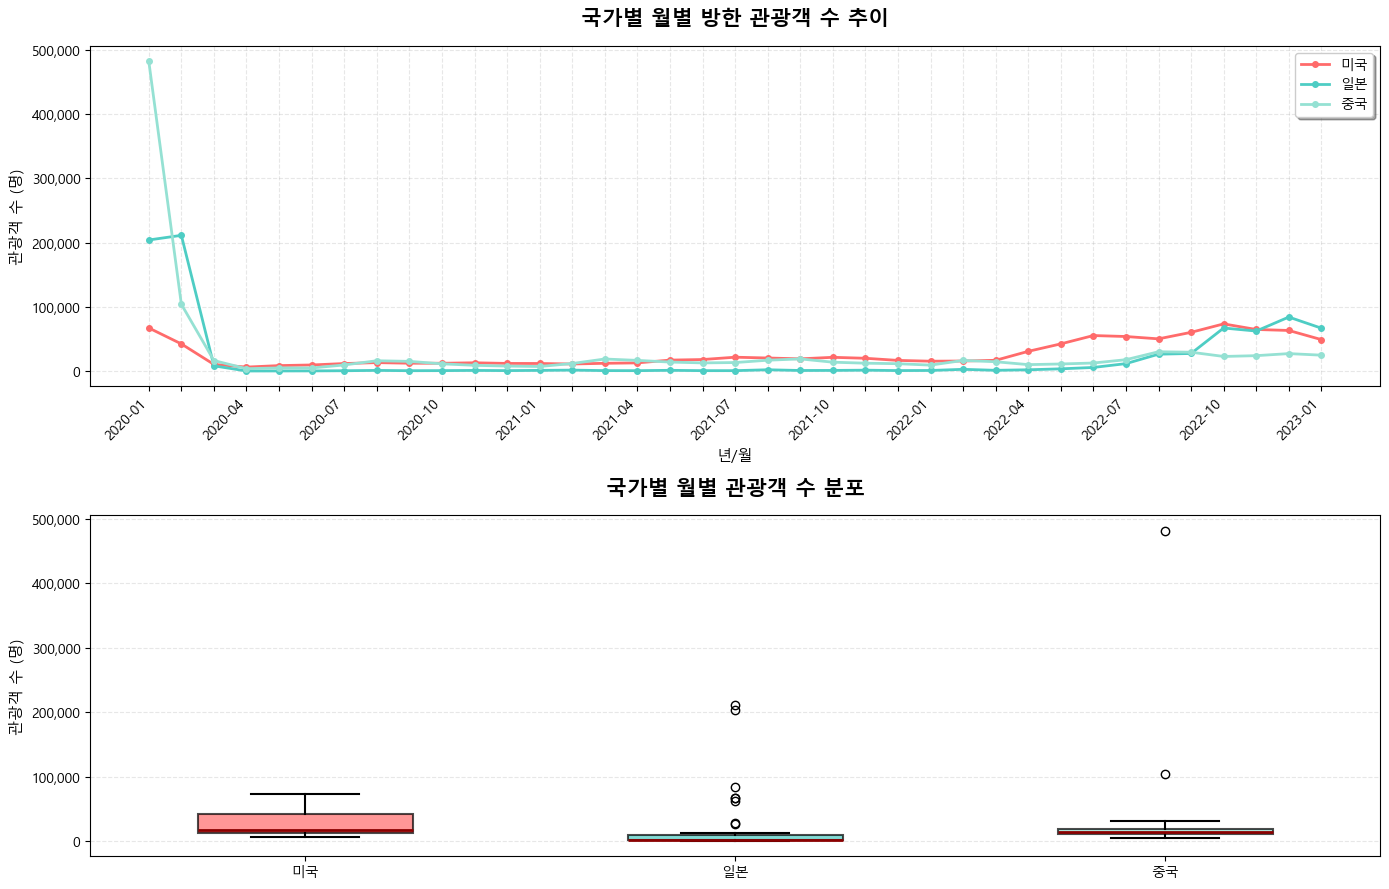

In [60]:
# 그래프 설정
fig, axes = plt.subplots(2, 1, figsize=(14, 9))
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

# 날짜를 문자열로 변환 (202001 -> '2020-01')
df_all['날짜_str'] = df_all['날짜'].astype(str).str[:4] + '-' + df_all['날짜'].astype(str).str[4:6]

# 1) 국가별 월별 관광객 수 추이
ax1 = axes[0]
for idx, country in enumerate(df_all['국가명'].unique()):
    country_df = df_all[df_all['국가명'] == country].sort_values('날짜')
    ax1.plot(country_df['날짜_str'], country_df['관광객수'], 
             linewidth=2, marker='o', markersize=4,
             color=colors[idx], label=country)

ax1.set_title('국가별 월별 방한 관광객 수 추이', fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('년/월', fontsize=11)
ax1.set_ylabel('관광객 수 (명)', fontsize=11)
ax1.legend(fontsize=10, frameon=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# X축 모든 날짜 표시 (3개월 간격)
unique_dates = sorted(df_all['날짜_str'].unique())
ax1.set_xticks(range(len(unique_dates)))
ax1.set_xticklabels(unique_dates, rotation=45, ha='right')
# 3개월 간격으로만 라벨 표시 (가독성을 위해)
for i, label in enumerate(ax1.xaxis.get_ticklabels()):
    if i % 3 != 0:
        label.set_visible(False)

# 2) 국가별 월별 관광객 수 분포
ax2 = axes[1]
data_by_country = [df_all[df_all['국가명'] == c]['관광객수'].values 
                   for c in df_all['국가명'].unique()]

bp = ax2.boxplot(data_by_country, 
                 labels=df_all['국가명'].unique(), 
                 patch_artist=True, 
                 widths=0.5,
                 boxprops=dict(linewidth=1.5),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5),
                 medianprops=dict(color='darkred', linewidth=2))

# 박스 색상 적용
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_title('국가별 월별 관광객 수 분포', fontsize=15, fontweight='bold', pad=15)
ax2.set_ylabel('관광객 수 (명)', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# 저장 및 표시
plt.tight_layout()
plt.savefig('./tourism_data/tourism_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41968\1604318973.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_by_country,


<Figure size 640x480 with 0 Axes>